<a href="https://colab.research.google.com/github/Mostafa-MMK/VaRBacktestingEngine/blob/main/03_Backtesting_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Backtesting VaR**

|  |  |
|:---|:---|
|**Developed By** |  Md Mostafa Kamal |
|**Date** | December 20, 2025  |
|**Topics** | VaR Backtesting, diagnostics, application |
|**Python** | OOP, Numpy, Pandas, Scienceplots, Matplotlib|
|**Sequence** | MR003 |


---

In [1]:
# Installing Packages
!pip install yfinance arch scienceplots --quiet
!apt-get update -qq
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# plt.style.use(['science', 'notebook', 'grid'])
# plt.rcParams['text.usetex'] = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.3 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base 

# Data Preparation

In [2]:
# Quickly download the data
symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
names = ['EURUSD', 'GOLD', 'GSPC', '10Y']

def calc_returns(symbols, names):
  import yfinance as yf
  import pandas as pd
  import numpy as np

  df = yf.download(symbols, start = '2020-01-01', auto_adjust= True)['Close'].dropna()
  df.columns = names
  df['10Y'] = df['10Y']/100
  df_returns = np.log(df/df.shift(1)).dropna()
  return df_returns

df_returns = calc_returns(symbols, names)
df_returns.tail()

[*********************100%***********************]  4 of 4 completed


,EURUSD,GOLD,GSPC,10Y
Date,,,,
2025-12-24,0.002509,-0.000491,0.003216,-0.007947
2025-12-26,-0.000861,0.010766,-0.000304,0.000000
2025-12-29,-0.001072,-0.046088,-0.003498,-0.004847
2025-12-30,0.000012,0.010351,-0.001377,0.003396
2025-12-31,-0.002176,-0.010235,-0.007385,0.007959


# VaR Calculations

## Historical Simulated VaR




In [3]:
import numpy as np
import pandas as pd

def historical_var_es(df_returns, confidence_level):

  # Sort the returns in ascending order
  sorted_returns = np.sort(df_returns)

  # Calculate VaR
  var_idx = int(np.floor((1 - confidence_level) * len(sorted_returns)))
  VaR = sorted_returns[var_idx]

  # Calculate ES
  losses_beyond_var = sorted_returns[sorted_returns <= VaR]
  ES = np.mean(losses_beyond_var)

  return VaR, ES


# Calculating VaR and ES for each asset for different confidence levels
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
  for asset in df_returns.columns:
    var, es = historical_var_es(df_returns[asset].values, confidence_level= confidence)
    results.append({
      'Asset': asset,
      'Confidence Level': f"{confidence*100:.0f}%",
      'VaR': var,
      'ES': es,
      'Method': 'HS'
    })

df_hs_results = pd.DataFrame(results)
# df_hs_results.set_index(['Asset'], inplace= True)
df_hs_results.head()

,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.005603,-0.008451,HS
1,GOLD,90%,-0.011923,-0.020078,HS
2,GSPC,90%,-0.012349,-0.023743,HS
3,10Y,90%,-0.029134,-0.057971,HS
4,EURUSD,91%,-0.005974,-0.008745,HS


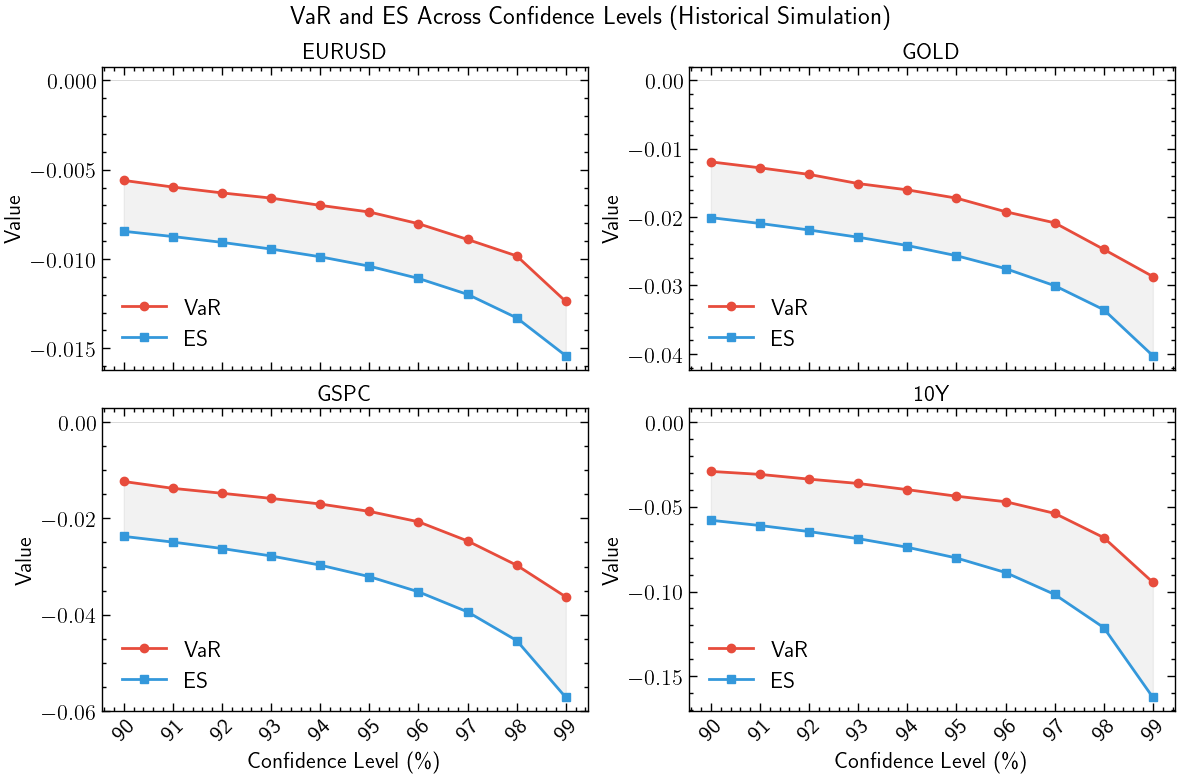

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_hs_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_hs_results[df_hs_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (Historical Simulation)', fontsize=18)
plt.tight_layout()
plt.show()

## Filtered Historical Simulated VaR

### EWMA VaR (RiskMetrics)

In [5]:
def calc_ewma_var_es_simple(df_returns, confidence_level, lambda_param=0.94):
    import numpy as np
    import pandas as pd

    # Convert to pandas Series
    if isinstance(df_returns, np.ndarray):
        returns = pd.Series(df_returns)
    else:
        returns = df_returns.copy()

    # Calculate the entire EWMA volatility series
    ewma_vol_series = np.sqrt(returns.ewm(alpha=1 - lambda_param).var())

    # Standardize returns
    standardized_returns = returns / ewma_vol_series

    # Get current volatility
    current_vol = ewma_vol_series.iloc[-1]

    # Sort the standardized returns
    sorted_z = np.sort(standardized_returns)

    # Calculate cutoff from sorted standardized returns
    var_idx = int(np.floor((1 - confidence_level) * len(sorted_z)))
    var_cutoff = sorted_z[var_idx]

    # Calculate VaR
    VaR = var_cutoff * current_vol

    # Calculate ES - IMPORTANT: compare with var_cutoff, not VaR
    es_losses = sorted_z[sorted_z <= var_cutoff]
    ES = np.mean(es_losses) * current_vol

    return VaR, ES

# Your loop with the corrected function:
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
    for asset in df_returns.columns:
        var, es = calc_ewma_var_es_simple(df_returns[asset], confidence_level=confidence)
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es,
            'Method': 'FHS-EWMA'
        })

df_ewma_results = pd.DataFrame(results)
df_ewma_results.head()

,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.002979,-0.004098,FHS-EWMA
1,GOLD,90%,-0.018340,-0.026591,FHS-EWMA
2,GSPC,90%,-0.007905,-0.012110,FHS-EWMA
3,10Y,90%,-0.008645,-0.012287,FHS-EWMA
4,EURUSD,91%,-0.003111,-0.004214,FHS-EWMA


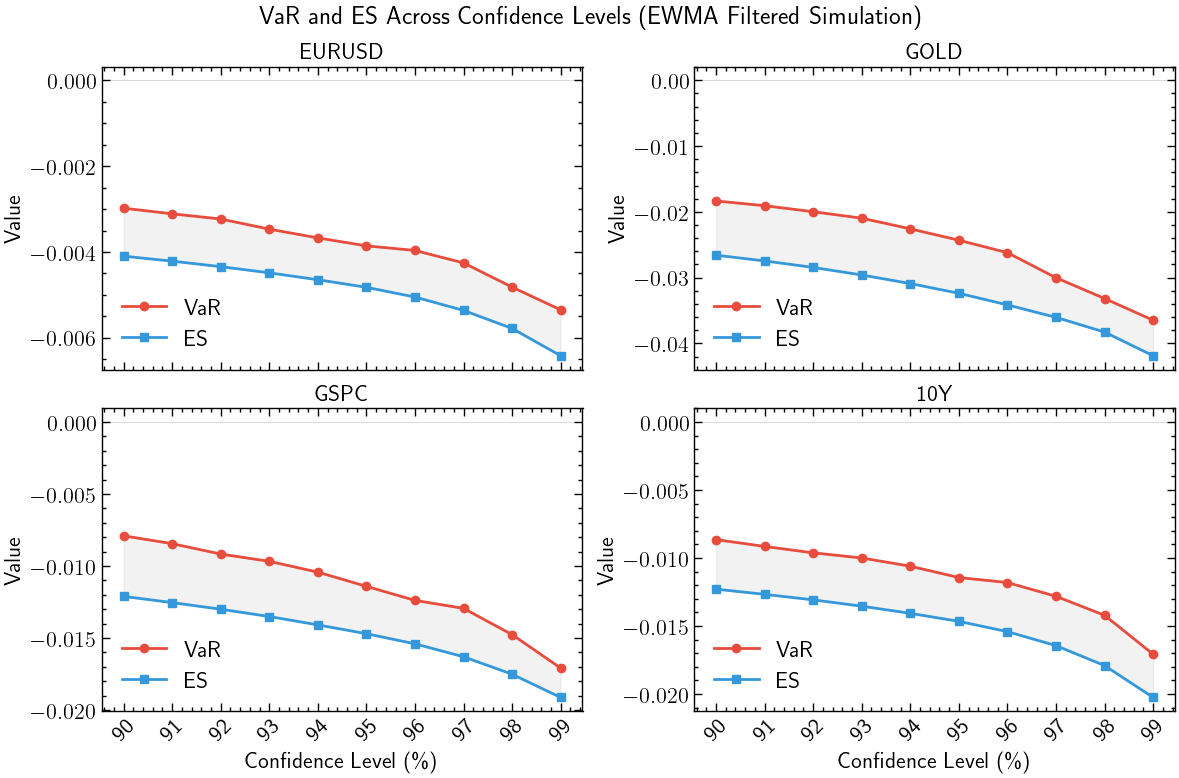

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_ewma_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_ewma_results[df_ewma_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (EWMA Filtered Simulation)', fontsize=18)
plt.tight_layout()
plt.show()

### GARCH (1, 1) VaR

In [7]:
def calc_garch_var_es(df_returns, confidence_level):
  import numpy as np
  import pandas as pd
  from arch import arch_model

  if isinstance(df_returns, np.ndarray):
    returns = pd.Series(df_returns)
  else:
    returns = df_returns.copy()

  # Fit Garch(1,1) model for the sample
  model = arch_model(returns, vol='Garch', p=1, q=1, dist = 'normal')
  garch_result = model.fit(disp='off', show_warning = False)

  # Getting Standardized residuals
  standardized_residuals = garch_result.resid / garch_result.conditional_volatility
  standardized_residuals = standardized_residuals.dropna()

  # Forecast next period vol
  forecast = garch_result.forecast(horizon=1, reindex = False)
  current_vol = np.sqrt(forecast.variance.values[-1, 0])

  # Sort and calculate VaR and ES
  sorted_residuals = np.sort(standardized_residuals)
  var_idx = int(np.floor((1 - confidence_level) * len(sorted_residuals)))
  var_cutoff = sorted_residuals[var_idx]
  VaR = var_cutoff * current_vol

  losses_beyond_var = sorted_residuals[sorted_residuals <= var_cutoff]
  ES = np.mean(losses_beyond_var) * current_vol

  return VaR, ES


# Main calculation following your exact workflow pattern
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
    for asset in df_returns.columns:
        # Use the simple version for the loop
        var, es = calc_garch_var_es(df_returns[asset], confidence_level=confidence)
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es,
            'Method': 'FHS-GARCH'
        })

df_garch_fhs_results = pd.DataFrame(results)
df_garch_fhs_results.head()


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.286e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.003804,-0.005712,FHS-GARCH
1,GOLD,90%,-0.018948,-0.029761,FHS-GARCH
2,GSPC,90%,-0.009100,-0.014762,FHS-GARCH
3,10Y,90%,-0.013889,-0.020942,FHS-GARCH
4,EURUSD,91%,-0.004025,-0.005914,FHS-GARCH


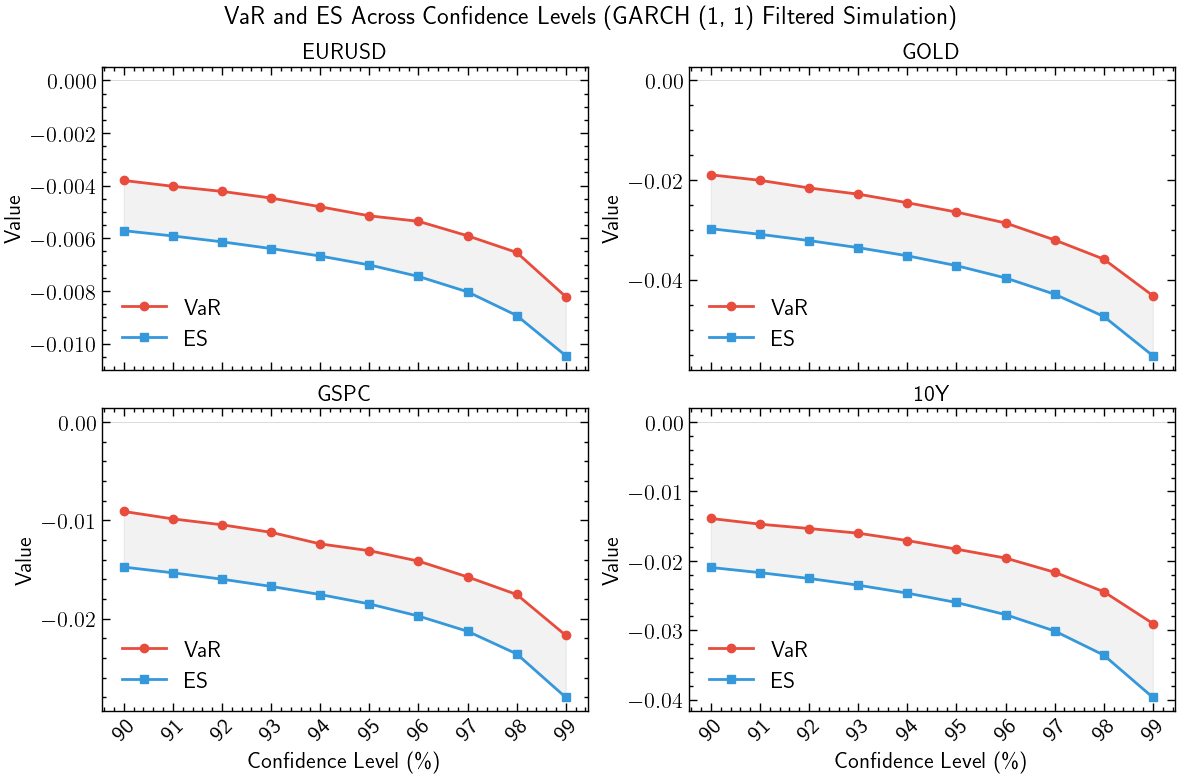

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_garch_fhs_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_garch_fhs_results[df_garch_fhs_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (GARCH (1, 1) Filtered Simulation)', fontsize=18)
plt.tight_layout()
plt.show()

## Monte Carlo VaR

### Normal Distribution

In [9]:
def calc_monte_carlo_var_es(df_returns, confidence_level, num_simulations=1000, seed = 1212):
  import numpy as np
  import pandas as pd
  from scipy.stats import norm
  np.random.seed(seed)

  if isinstance(df_returns, np.ndarray):
    returns = pd.Series(df_returns)
  else:
    returns = df_returns.copy()

  # Calculate mean and standard deviation
  mean_return = returns.mean()
  std_return = returns.std()

  # Monte Carlo simulated returns (Normal Distributions)
  simulated_returns = np.random.normal(loc = mean_return, scale= std_return, size = num_simulations)

  # Sort simulated returns (ascending order, most negative first)
  sorted_returns = np.sort(simulated_returns)

  # Calculated cutoff index from sorted simulated returns
  var_idx = int(np.floor((1 - confidence_level) * num_simulations))
  var_cutoff = sorted_returns[var_idx]
  VaR = var_cutoff

  # Calculate ES
  losses_beyond_var = sorted_returns[sorted_returns <= var_cutoff]
  ES = np.mean(losses_beyond_var)

  return VaR, ES


# Main calculation following your exact workflow pattern
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
    for asset in df_returns.columns:
        # Use the simple version for the loop
        var, es = calc_monte_carlo_var_es(df_returns[asset], confidence_level=confidence, num_simulations=10000)
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es,
            'Method': 'MC-Normal'
        })

df_monte_normal_results = pd.DataFrame(results)
df_monte_normal_results.head()



,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.006104,-0.008280,MC-Normal
1,GOLD,90%,-0.013125,-0.018026,MC-Normal
2,GSPC,90%,-0.016434,-0.022439,MC-Normal
3,10Y,90%,-0.045065,-0.061239,MC-Normal
4,EURUSD,91%,-0.006390,-0.008508,MC-Normal


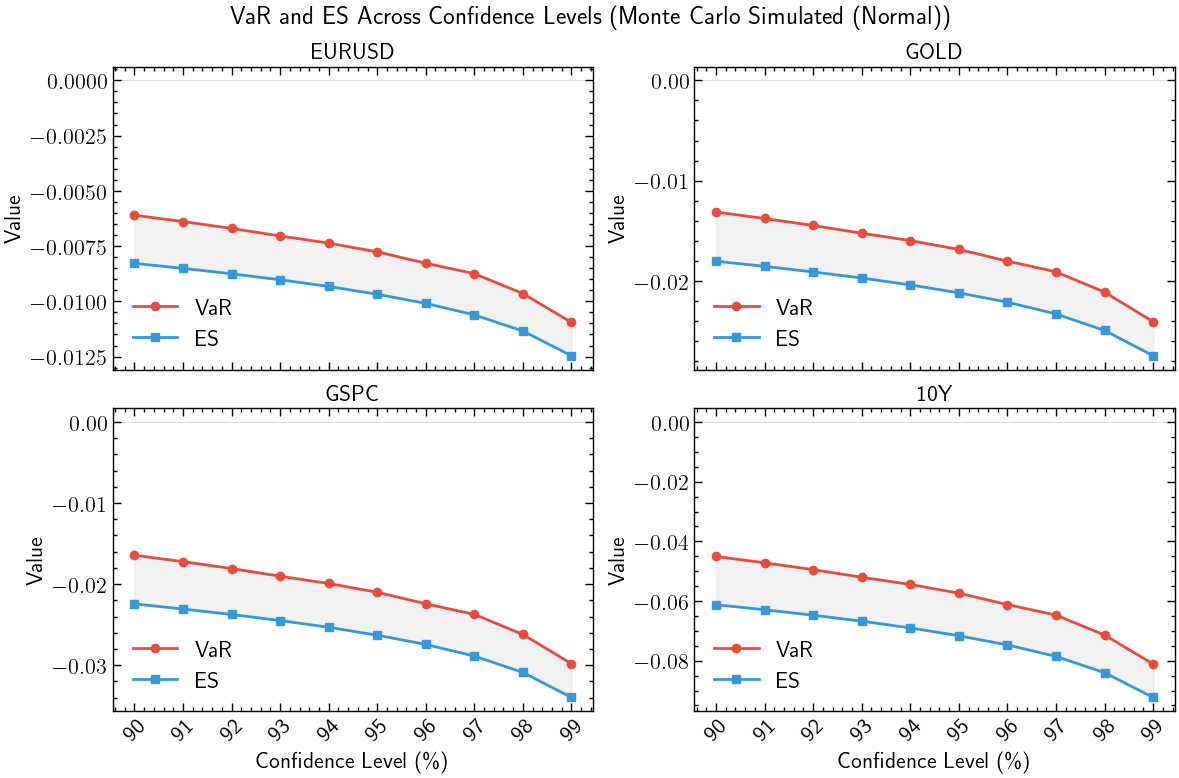

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_monte_normal_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_monte_normal_results[df_monte_normal_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (Monte Carlo Simulated (Normal))', fontsize=18)
plt.tight_layout()
plt.show()

### Student t-Distribution

In [11]:
from math import degrees
def calc_monte_carlo_t_var_es(df_returns, confidence_level, num_simulations=1000, seed = 1213):
  import numpy as np
  import pandas as pd
  from scipy.stats import t

  np.random.seed(seed)

  if isinstance(df_returns, np.ndarray):
    returns = pd.Series(df_returns)
  else:
    returns = df_returns.copy()

  # Calculate parameters from historical returns
  mean_return = returns.mean()
  std_return = returns.std()
  df, loc, scale = t.fit(returns, method='mle')
  degrees_of_freedom = df

  # Generate Monte Carlo Simulation from t-distributions
  simulated_returns = t.rvs(df=degrees_of_freedom, loc=loc, scale=scale, size=num_simulations)

  # Sort simulated returns
  sorted_simulated_returns = np.sort(simulated_returns)

  # Calculate VaR
  var_idx = int(np.floor((1 - confidence_level) * num_simulations))
  var_cutoff = sorted_simulated_returns[var_idx]
  VaR = var_cutoff

  # Calculate ES
  losses_beyond_var = sorted_simulated_returns[sorted_simulated_returns <= var_cutoff]
  ES = np.mean(losses_beyond_var)

  return VaR, ES, degrees_of_freedom



# Main calculation following the exact same workflow pattern
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

SEED = 42

for confidence in confidence_levels:
    for asset in df_returns.columns:
        var, es, df_param = calc_monte_carlo_t_var_es(
            df_returns[asset],
            confidence_level=confidence,
            num_simulations=10000,
            seed=SEED
        )
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es,
            # 'Degrees of Freedom': df_param,
            'Method': 'MC-t',
            # 'Seed': SEED
        })

df_monte_t_results = pd.DataFrame(results)
df_monte_t_results.head()


,Asset,Confidence Level,VaR,ES,Method
0,EURUSD,90%,-0.005605,-0.008520,MC-t
1,GOLD,90%,-0.010688,-0.018562,MC-t
2,GSPC,90%,-0.011480,-0.021882,MC-t
3,10Y,90%,-0.029811,-0.057456,MC-t
4,EURUSD,91%,-0.005944,-0.008827,MC-t


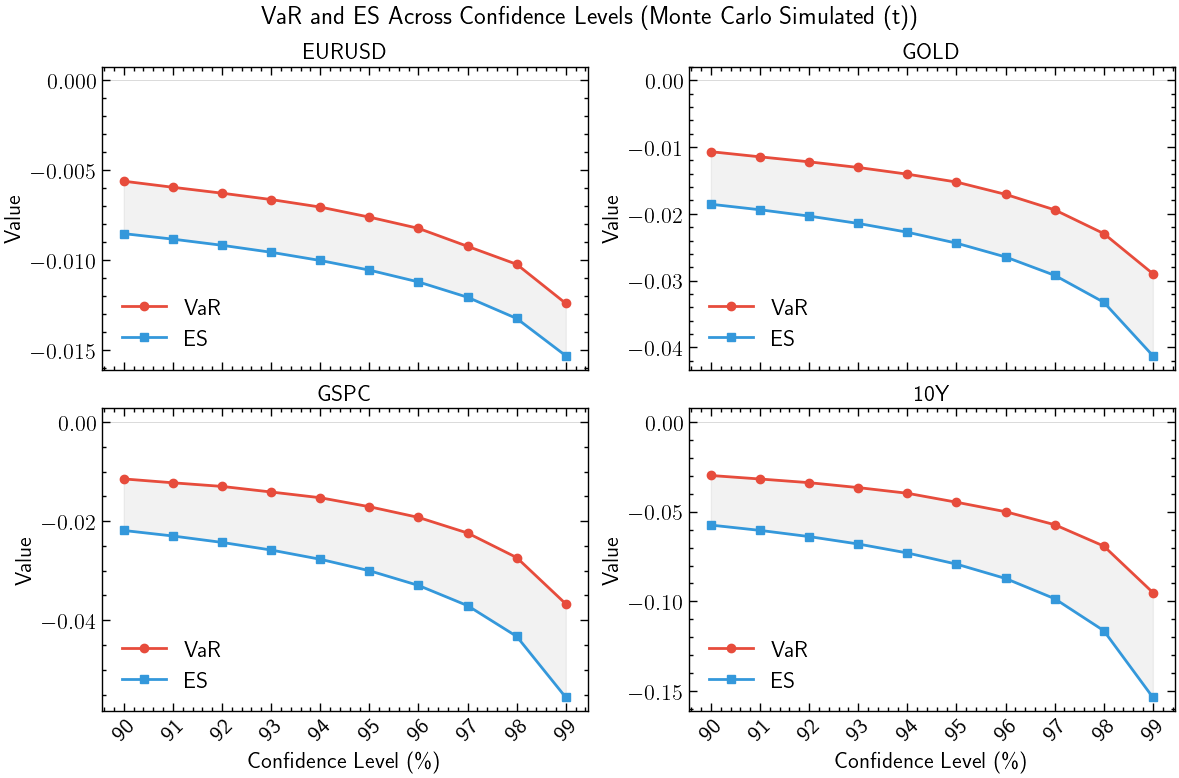

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

# Get first 4 assets
assets = df_monte_t_results['Asset'].unique()[:4]

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Colors
var_color, es_color = '#E74C3C', '#3498DB'  # Red, Blue

# We need to collect all x-ticks for proper sharing
all_conf_levels = []
all_conf_labels = []

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter and sort data
    asset_data = df_monte_t_results[df_monte_t_results['Asset'] == asset].copy()
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Store for later use
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    if idx == 0:  # Store from first plot
        all_conf_levels = conf_levels
        all_conf_labels = conf_labels

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', label='VaR', linewidth=2, color=var_color)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', label='ES', linewidth=2, color=es_color)

    # Fill between
    ax.fill_between(conf_levels,
                    asset_data['VaR'], asset_data['ES'],
                    alpha=0.1, color='gray')

    # Set labels
    ax.set_title(f'{asset}', fontweight='bold')

    # Only set xlabel for bottom row
    if idx >= 2:  # Bottom row in 2x2 grid (indices 2 and 3)
        ax.set_xlabel(r'Confidence Level (\%)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Value')

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add legend
    ax.legend(frameon=False)
    ax.grid(False)

# Now set consistent x-ticks for all subplots
for idx, asset in enumerate(assets):
    axes[idx].set_xticks(all_conf_levels)
    axes[idx].set_xticklabels(all_conf_labels, rotation=45)

# Hide empty subplots if less than 4 assets
for idx in range(len(assets), 4):
    axes[idx].set_visible(False)

plt.suptitle('VaR and ES Across Confidence Levels (Monte Carlo Simulated (t))', fontsize=18)
plt.tight_layout()
plt.show()

# Backtesting VaR

## Historical Simulated VaR

[*********************100%***********************]  4 of 4 completed


Running VaR backtest...
VaR BACKTESTING RESULTS SUMMARY

PORTFOLIO RESULTS:
----------------------------------------
Observations: 1254
VaR Violations: 52
Violation Rate: 4.15% (Expected: 5.00%)
Kupiec Test P-value: 0.1537
✓ VaR model is accurate at 95% confidence level

Conditional Coverage P-value: 0.1800
✓ No clustering in violations detected

Average VaR: -1.1274%
Average ES: -1.6058%
Quantile Loss: 0.000756

INDIVIDUAL ASSET RESULTS:
----------------------------------------------------------------------
 Asset  Violations Violation Rate Kupiec P-value  Avg VaR
  GSPC          70          5.58%         0.3527 -0.7603%
  GOLD          65          5.18%         0.7670 -1.6780%
   10Y          58          4.63%         0.5376 -1.8357%
EURUSD          45          3.59%         0.0159 -3.8275%


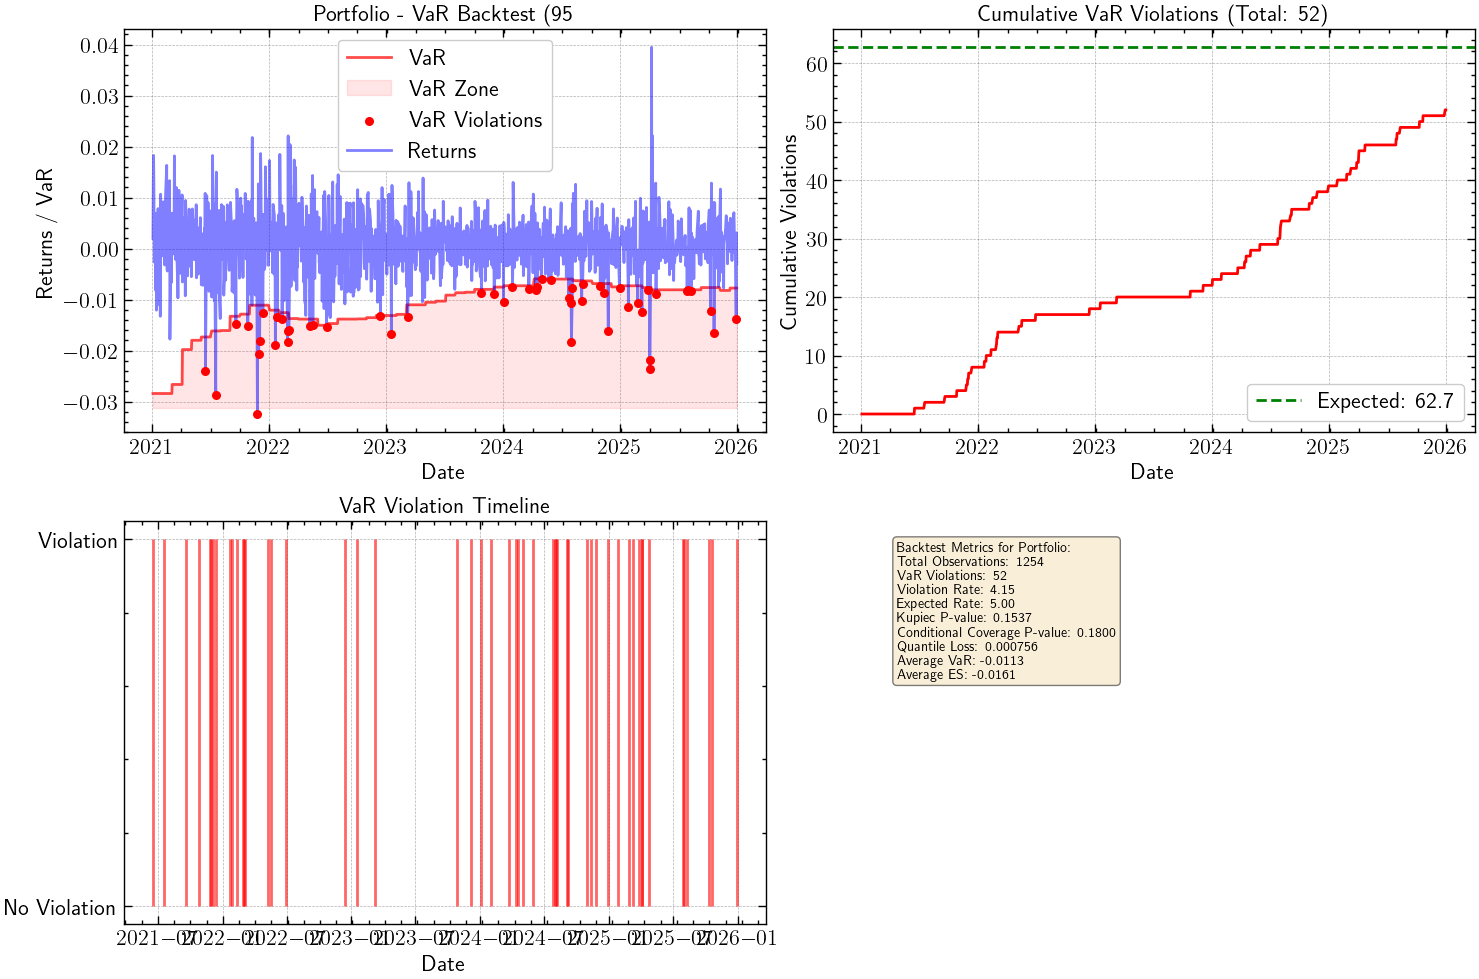

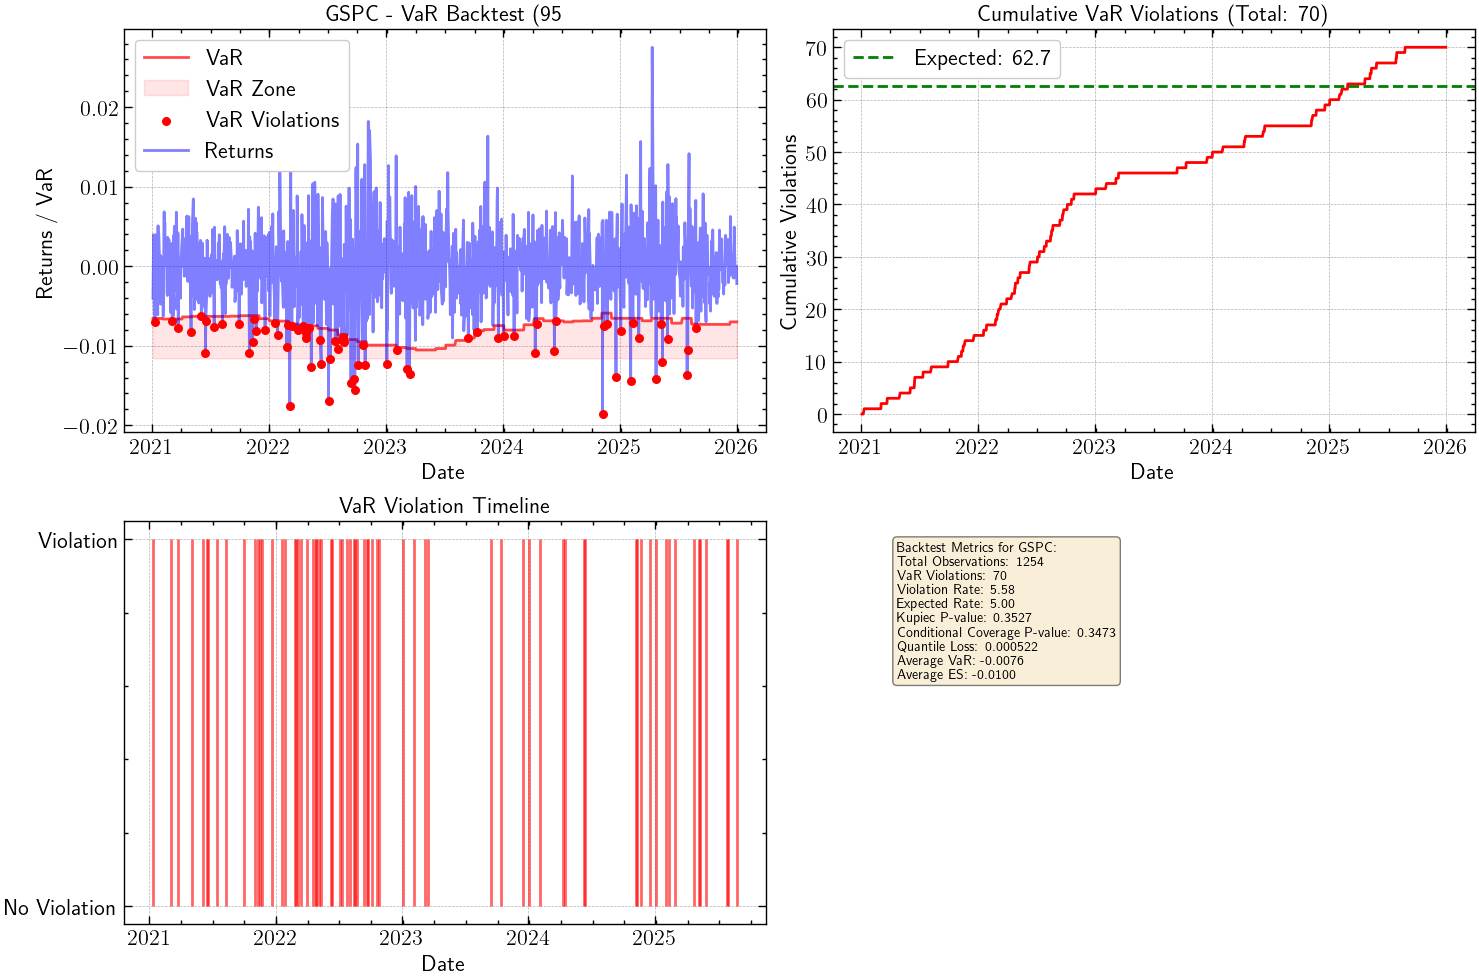

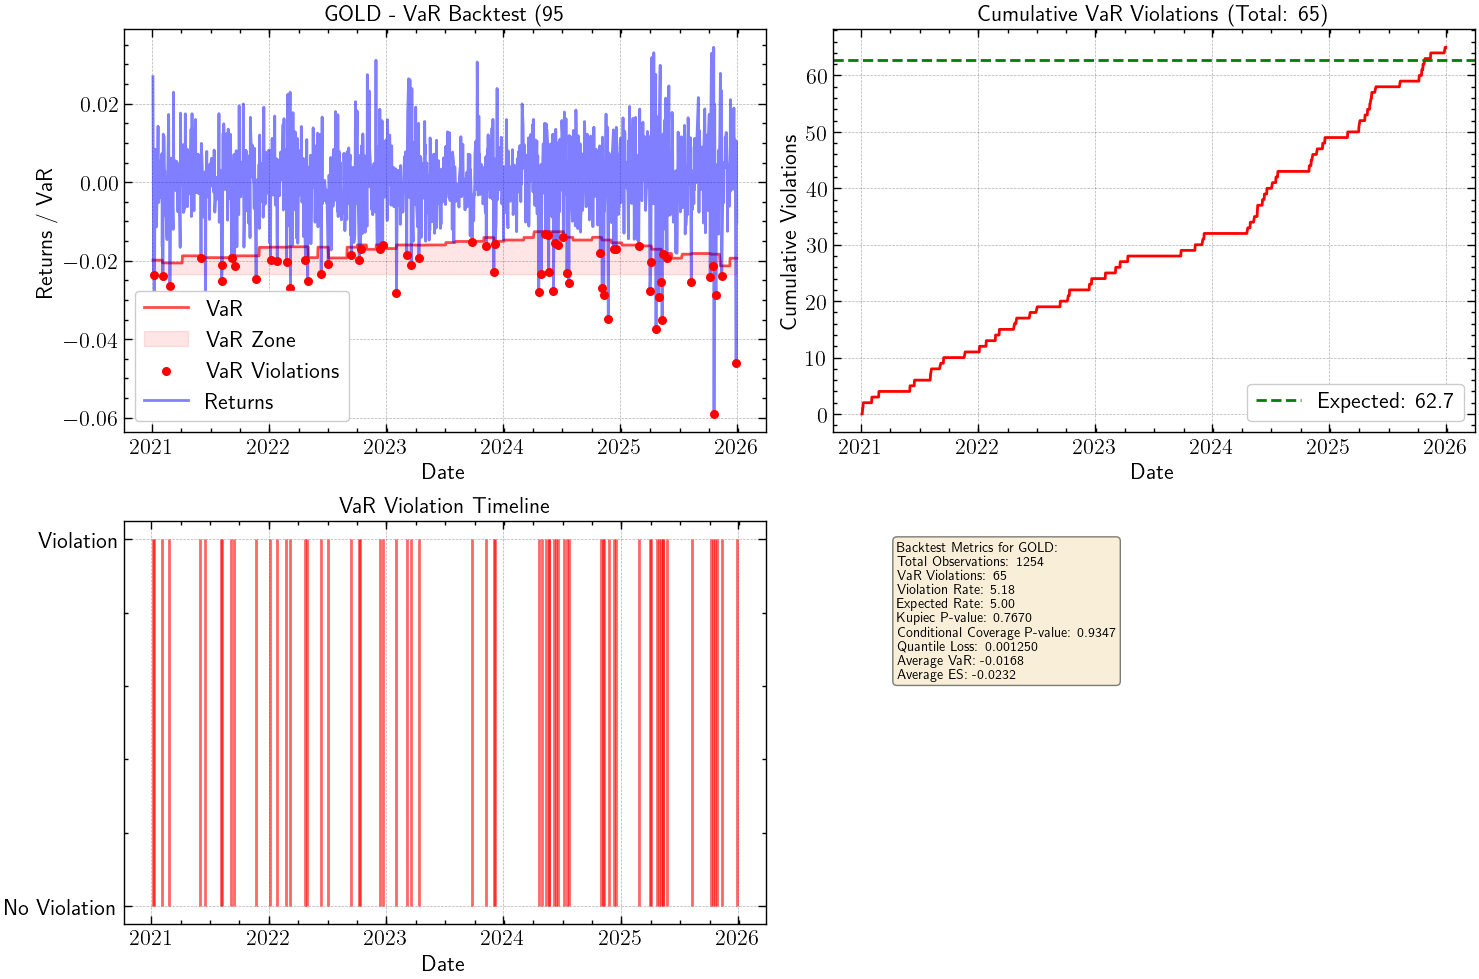

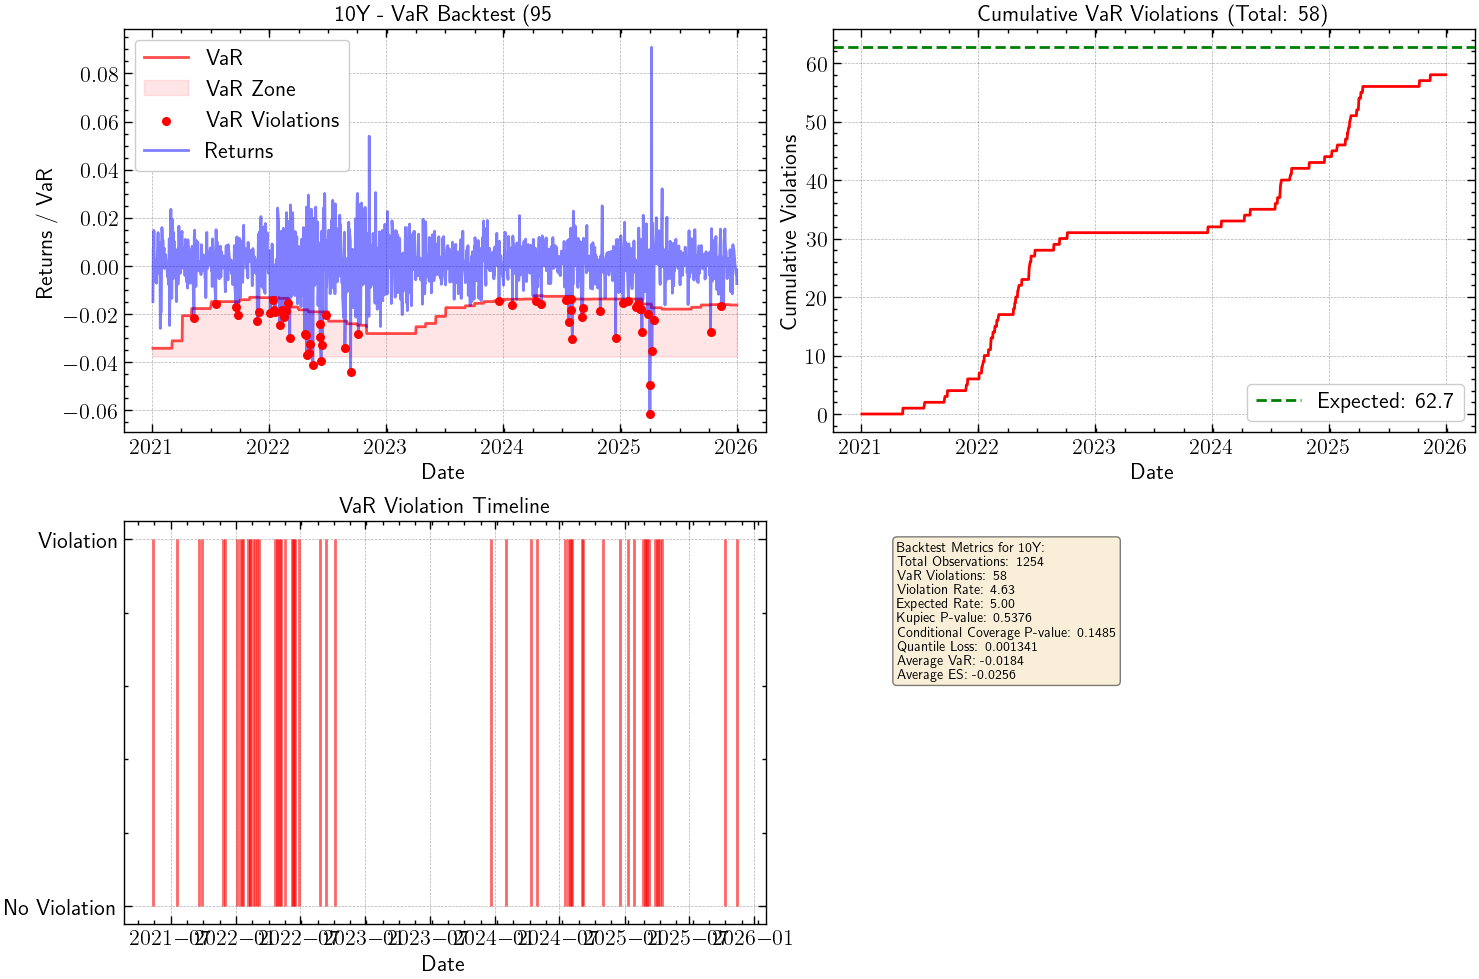

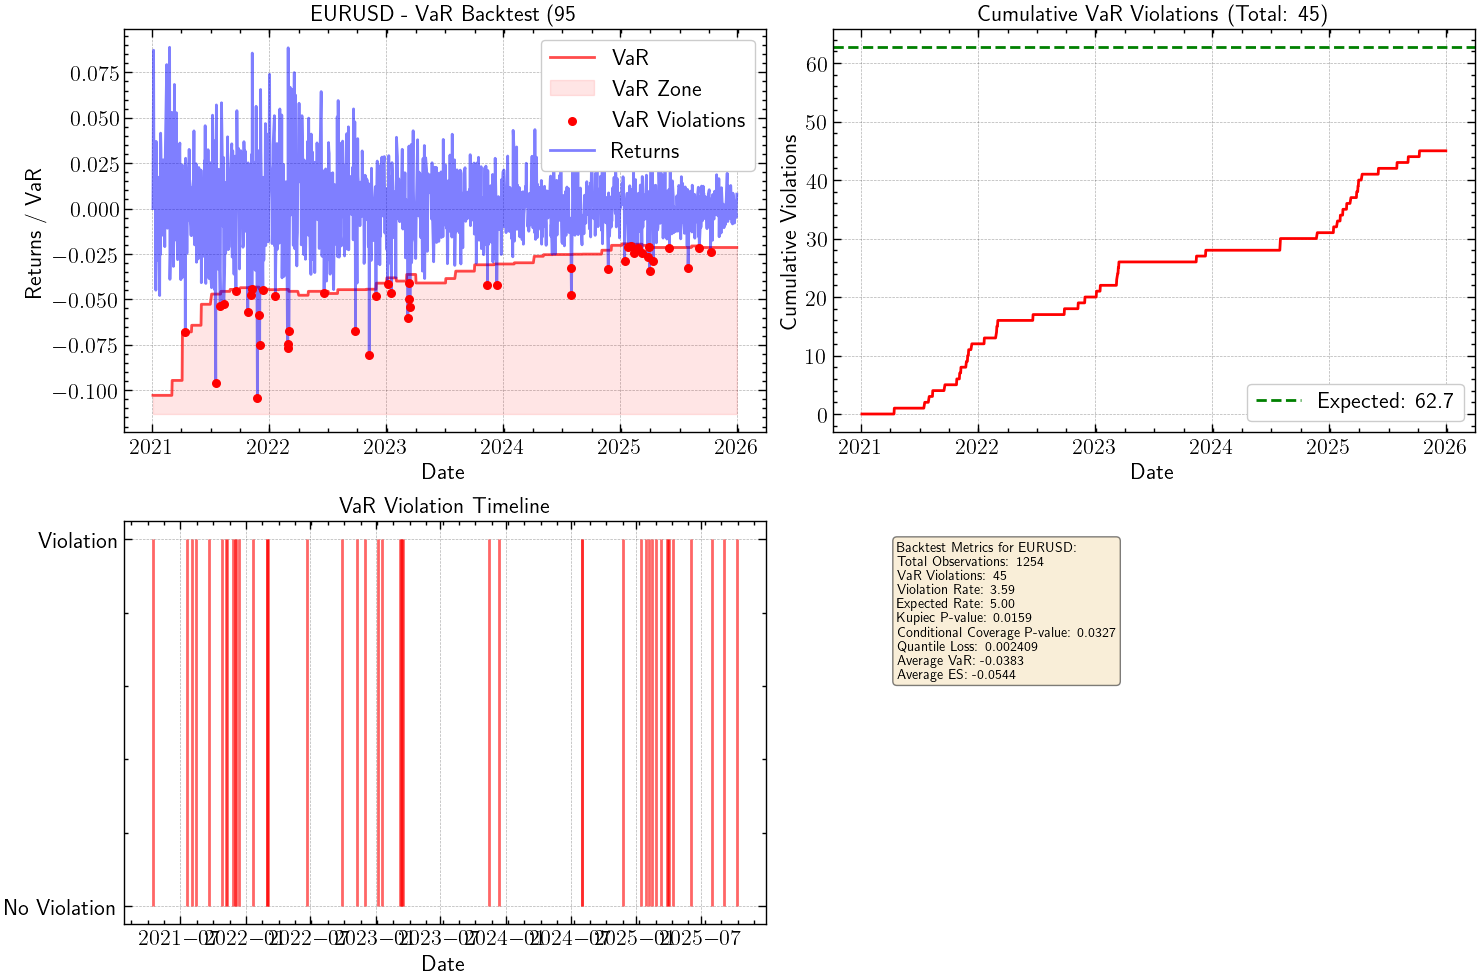

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def historical_var_es(df_returns, confidence_level):
    """Calculate Historical VaR and Expected Shortfall"""
    # Sort the returns in ascending order
    sorted_returns = np.sort(df_returns)

    # Calculate VaR
    var_idx = int(np.floor((1 - confidence_level) * len(sorted_returns)))
    VaR = sorted_returns[var_idx]

    # Calculate ES
    losses_beyond_var = sorted_returns[sorted_returns <= VaR]
    ES = np.mean(losses_beyond_var)

    return VaR, ES

def backtest_var(df_returns, confidence_level=0.95, window_size=252, refit_freq=63):
    """
    Backtest VaR model using rolling window approach

    Parameters:
    -----------
    df_returns : pandas DataFrame or Series
        Asset returns
    confidence_level : float
        VaR confidence level (e.g., 0.95 for 95%)
    window_size : int
        Rolling window size for VaR estimation
    refit_freq : int
        Frequency to refit the VaR model (in days)

    Returns:
    --------
    dict : Backtesting results including various metrics
    """

    results = {}

    if isinstance(df_returns, pd.DataFrame):
        # If DataFrame, backtest each column
        portfolio_returns = df_returns.mean(axis=1)  # Equal-weighted portfolio
        asset_results = {}
        for asset in df_returns.columns:
            asset_results[asset] = _single_asset_backtest(
                df_returns[asset], confidence_level, window_size, refit_freq
            )
        results['asset_results'] = asset_results

    # Backtest portfolio returns
    portfolio_results = _single_asset_backtest(
        portfolio_returns, confidence_level, window_size, refit_freq
    )
    results['portfolio'] = portfolio_results

    return results

def _single_asset_backtest(returns, confidence_level, window_size, refit_freq):
    """Backtest VaR for a single asset"""

    n_obs = len(returns)
    var_predictions = pd.Series(index=returns.index, dtype=float)
    es_predictions = pd.Series(index=returns.index, dtype=float)
    exceptions = pd.Series(index=returns.index, dtype=bool)

    # Rolling window backtest
    for i in range(window_size, n_obs):
        if (i - window_size) % refit_freq == 0:
            window_returns = returns.iloc[i-window_size:i]

            # Calculate VaR and ES for the next period
            VaR, ES = historical_var_es(window_returns, confidence_level)

        var_predictions.iloc[i] = VaR
        es_predictions.iloc[i] = ES

        # Check if return violates VaR
        exceptions.iloc[i] = returns.iloc[i] < VaR

    # Remove initial NaN values
    valid_idx = ~var_predictions.isna()
    var_predictions = var_predictions[valid_idx]
    es_predictions = es_predictions[valid_idx]
    exceptions = exceptions[valid_idx]
    backtest_returns = returns[valid_idx]

    # Calculate backtest metrics
    metrics = calculate_backtest_metrics(
        backtest_returns, var_predictions, es_predictions,
        exceptions, confidence_level
    )

    return {
        'VaR_predictions': var_predictions,
        'ES_predictions': es_predictions,
        'exceptions': exceptions,
        'metrics': metrics
    }

def calculate_backtest_metrics(returns, var_pred, es_pred, exceptions, confidence_level):
    """Calculate various backtest metrics"""

    n = len(exceptions)
    n_exceptions = exceptions.sum()
    exception_rate = n_exceptions / n

    expected_exceptions = (1 - confidence_level) * n
    unconditional_coverage = exception_rate

    # 1. Kupiec's POF Test (Proportion of Failures)
    try:
        LR_uc = -2 * np.log(
            ((1 - (1 - confidence_level)) ** (n - n_exceptions) *
             (1 - confidence_level) ** n_exceptions) /
            ((1 - exception_rate) ** (n - n_exceptions) *
             exception_rate ** n_exceptions)
        )
        p_value_uc = 1 - stats.chi2.cdf(LR_uc, 1)
    except:
        LR_uc = np.nan
        p_value_uc = np.nan

    # 2. Conditional Coverage Test (Christoffersen)
    # Calculate transition matrix
    exceptions_series = exceptions.astype(int)

    # Count transitions
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(exceptions_series)):
        if exceptions_series.iloc[i-1] == 0 and exceptions_series.iloc[i] == 0:
            n00 += 1
        elif exceptions_series.iloc[i-1] == 0 and exceptions_series.iloc[i] == 1:
            n01 += 1
        elif exceptions_series.iloc[i-1] == 1 and exceptions_series.iloc[i] == 0:
            n10 += 1
        elif exceptions_series.iloc[i-1] == 1 and exceptions_series.iloc[i] == 1:
            n11 += 1

    # Calculate probabilities
    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)

    # Likelihood ratio for independence
    try:
        L_ind = ((1 - pi) ** (n00 + n10) * pi ** (n01 + n11))
        L_cc = ((1 - pi0) ** n00 * pi0 ** n01 * (1 - pi1) ** n10 * pi1 ** n11)
        LR_ind = -2 * np.log(L_ind / L_cc)
        p_value_ind = 1 - stats.chi2.cdf(LR_ind, 1)

        # Conditional coverage test
        LR_cc = LR_uc + LR_ind
        p_value_cc = 1 - stats.chi2.cdf(LR_cc, 2)
    except:
        LR_ind = np.nan
        p_value_ind = np.nan
        LR_cc = np.nan
        p_value_cc = np.nan

    # 3. Quantile Loss Function (QLF)
    alpha = 1 - confidence_level
    qlf = np.mean(alpha * (returns - var_pred).clip(lower=0) +
                  (1 - alpha) * (var_pred - returns).clip(lower=0))

    # 4. ES Backtest (Acerbi & Szekely, 2014)
    violation_returns = returns[exceptions]
    if len(violation_returns) > 0:
        es_test_stat = 1 + np.mean(violation_returns) / es_pred[exceptions].mean()
    else:
        es_test_stat = np.nan

    metrics = {
        'n_observations': n,
        'n_exceptions': int(n_exceptions),
        'exception_rate': exception_rate,
        'expected_exception_rate': 1 - confidence_level,
        'expected_exceptions': expected_exceptions,
        'unconditional_coverage_pvalue': p_value_uc,
        'independence_pvalue': p_value_ind,
        'conditional_coverage_pvalue': p_value_cc,
        'quantile_loss': qlf,
        'es_test_statistic': es_test_stat,
        'average_VaR': var_pred.mean(),
        'average_ES': es_pred.mean(),
        'max_violation': violation_returns.min() if len(violation_returns) > 0 else np.nan,
        'violation_cluster': n11  # Number of consecutive violations
    }

    return metrics

def plot_backtest_results(backtest_results, asset_name='Portfolio'):
    """Plot backtest results"""

    if asset_name in backtest_results:
        results = backtest_results[asset_name]
    else:
        results = backtest_results['portfolio']

    var_pred = results['VaR_predictions']
    returns = var_pred.index.map(lambda x: df_returns.loc[x].mean() if asset_name == 'Portfolio' else df_returns.loc[x, asset_name])
    exceptions = results['exceptions']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. VaR vs Returns plot
    ax = axes[0, 0]
    ax.plot(var_pred.index, var_pred.values, 'r-', label='VaR', alpha=0.7)
    ax.fill_between(var_pred.index, var_pred.values, var_pred.values.min() * 1.1,
                    color='red', alpha=0.1, label='VaR Zone')
    ax.scatter(var_pred.index[exceptions], returns[exceptions],
               color='red', s=30, label='VaR Violations', zorder=5)
    ax.plot(var_pred.index, returns.values, 'b-', alpha=0.5, label='Returns')
    ax.set_title(f'{asset_name} - VaR Backtest (95% Confidence)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns / VaR')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Cumulative violations
    ax = axes[0, 1]
    cumulative_violations = exceptions.cumsum()
    ax.plot(cumulative_violations.index, cumulative_violations.values, 'r-', linewidth=2)
    ax.axhline(y=results['metrics']['expected_exceptions'], color='g',
               linestyle='--', label=f'Expected: {results["metrics"]["expected_exceptions"]:.1f}')
    ax.set_title(f'Cumulative VaR Violations (Total: {results["metrics"]["n_exceptions"]})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Violations')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Violation timeline
    ax = axes[1, 0]
    violation_dates = exceptions[exceptions].index
    if len(violation_dates) > 0:
        ax.vlines(violation_dates, ymin=0, ymax=1, color='red', alpha=0.6, linewidth=2)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['No Violation', 'Violation'])
        ax.set_title('VaR Violation Timeline')
        ax.set_xlabel('Date')
        ax.grid(True, alpha=0.3)

    # 4. Metrics table
    ax = axes[1, 1]
    ax.axis('tight')
    ax.axis('off')

    metrics_text = [
        f"Backtest Metrics for {asset_name}:",
        f"Total Observations: {results['metrics']['n_observations']}",
        f"VaR Violations: {results['metrics']['n_exceptions']}",
        f"Violation Rate: {results['metrics']['exception_rate']*100:.2f}%",
        f"Expected Rate: {results['metrics']['expected_exception_rate']*100:.2f}%",
        f"Kupiec P-value: {results['metrics']['unconditional_coverage_pvalue']:.4f}",
        f"Conditional Coverage P-value: {results['metrics']['conditional_coverage_pvalue']:.4f}",
        f"Quantile Loss: {results['metrics']['quantile_loss']:.6f}",
        f"Average VaR: {results['metrics']['average_VaR']:.4f}",
        f"Average ES: {results['metrics']['average_ES']:.4f}"
    ]

    ax.text(0.1, 0.95, '\n'.join(metrics_text), transform=ax.transAxes,
            verticalalignment='top', fontsize=10, family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

def print_backtest_summary(backtest_results):
    """Print comprehensive backtest summary"""

    print("=" * 70)
    print("VaR BACKTESTING RESULTS SUMMARY")
    print("=" * 70)

    # Portfolio results
    portfolio = backtest_results['portfolio']
    metrics = portfolio['metrics']

    print("\nPORTFOLIO RESULTS:")
    print("-" * 40)
    print(f"Observations: {metrics['n_observations']}")
    print(f"VaR Violations: {metrics['n_exceptions']}")
    print(f"Violation Rate: {metrics['exception_rate']*100:.2f}% (Expected: {metrics['expected_exception_rate']*100:.2f}%)")
    print(f"Kupiec Test P-value: {metrics['unconditional_coverage_pvalue']:.4f}")

    if metrics['unconditional_coverage_pvalue'] > 0.05:
        print("✓ VaR model is accurate at 95% confidence level")
    else:
        print("✗ VaR model may be inaccurate")

    print(f"\nConditional Coverage P-value: {metrics['conditional_coverage_pvalue']:.4f}")
    if metrics['conditional_coverage_pvalue'] > 0.05:
        print("✓ No clustering in violations detected")
    else:
        print("✗ Potential clustering in violations")

    print(f"\nAverage VaR: {metrics['average_VaR']:.4%}")
    print(f"Average ES: {metrics['average_ES']:.4%}")
    print(f"Quantile Loss: {metrics['quantile_loss']:.6f}")

    # Individual asset results
    if 'asset_results' in backtest_results:
        print("\n" + "=" * 70)
        print("INDIVIDUAL ASSET RESULTS:")
        print("-" * 70)

        summary_data = []
        for asset, result in backtest_results['asset_results'].items():
            m = result['metrics']
            summary_data.append({
                'Asset': asset,
                'Violations': m['n_exceptions'],
                'Violation Rate': f"{m['exception_rate']*100:.2f}%",
                'Kupiec P-value': f"{m['unconditional_coverage_pvalue']:.4f}",
                'Avg VaR': f"{m['average_VaR']:.4%}"
            })

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

# Download data and run backtest
symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
names = ['GSPC', 'GOLD', '10Y', 'EURUSD']

def calc_returns(symbols, names):
    import yfinance as yf
    df = yf.download(symbols, start='2020-01-01', auto_adjust=True)['Close'].dropna()
    df.columns = names
    df['10Y'] = df['10Y']/100  # Convert yield to decimal
    df_returns = np.log(df/df.shift(1)).dropna()
    return df_returns

# Calculate returns
df_returns = calc_returns(symbols, names)

# Run backtest
print("Running VaR backtest...")
backtest_results = backtest_var(df_returns, confidence_level=0.95, window_size=252, refit_freq=21)

# Print summary
print_backtest_summary(backtest_results)

# Plot results
plot_backtest_results(backtest_results, asset_name='Portfolio')

# Plot individual assets if needed
if 'asset_results' in backtest_results:
    for asset in df_returns.columns:
        plot_backtest_results(backtest_results['asset_results'], asset_name=asset)